In [ ]:
!pip install -q faster-whisper jiwer py7zr librosa pandas tqdm py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 48.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.2/494.2 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.8/38.8 MB 49.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 98.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 83.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━

In [17]:
import os
import py7zr
import pandas as pd
import numpy as np
import librosa
from faster_whisper import WhisperModel
from jiwer import wer, cer
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import re
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [18]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

COMMON_VOICE_PATH = "/kaggle/input/common-voice"
LIBRI_NOISE_PATH = "/kaggle/input/libri-speech-noise-dataset"
OUT_DIR = "/kaggle/working"

os.makedirs(OUT_DIR, exist_ok=True)

# MODEL LOADING

In [19]:
models_to_test = {
    'tiny': {'model': None, 'results': {}, 'color': '#FF6B6B'},
    'base': {'model': None, 'results': {}, 'color': '#4ECDC4'},
    'small': {'model': None, 'results': {}, 'color': '#45B7D1'},
    'medium': {'model': None, 'results': {}, 'color': '#FFA07A'},
    'large-v3': {'model': None, 'results': {}, 'color': '#98D8C8'}
}

for model_name in models_to_test.keys():
    print(f"\nLoading Whisper {model_name}...")
    try:
        models_to_test[model_name]['model'] = WhisperModel(
            model_name, 
            device="cuda", 
            compute_type="float16"
        )
        print(f"{model_name} loaded successfully")
    except Exception as e:
        print(f"Failed to load {model_name}: {e}")


Loading Whisper tiny...
tiny loaded successfully

Loading Whisper base...
base loaded successfully

Loading Whisper small...
small loaded successfully

Loading Whisper medium...
medium loaded successfully

Loading Whisper large-v3...
large-v3 loaded successfully


# DATASET PREPARATION

## Load Common Voice

In [20]:
cv_path = os.path.join(COMMON_VOICE_PATH, "cv-valid-test.csv")
cv_df = pd.read_csv(cv_path).head(50)
print(f"Common Voice: {len(cv_df)} samples loaded")

Common Voice: 50 samples loaded


## Load LibriSpeech-Noise


In [21]:
ls_archive = os.path.join(LIBRI_NOISE_PATH, "test.7z")
print("Extracting LibriSpeech-Noise samples...")
with py7zr.SevenZipFile(ls_archive, mode='r') as z:
    all_files = z.getnames()
    audio_files = [f for f in all_files if f.endswith('.wav') or f.endswith('.mp3')][:50]
    z.extract(targets=audio_files, path=OUT_DIR)

ls_files = [os.path.join(OUT_DIR, f) for f in audio_files]
print(f"LibriSpeech-Noise: {len(ls_files)} samples extracted")

Extracting LibriSpeech-Noise samples...
LibriSpeech-Noise: 50 samples extracted


# TRANSCRIPTION FUNCTION

In [23]:
def transcribe_audio(audio_path, model):
    """Transcribe audio using specified Whisper model"""
    try:
        audio, _ = librosa.load(audio_path, sr=16000)
        segments, _ = model.transcribe(audio, beam_size=5, language="en")
        return " ".join([s.text for s in segments]).strip().lower()
    except:
        return ""

In [24]:
def post_process(text):
    """Clean and normalize transcription text"""
    text = re.sub(r',(\s*[.!?])', r'\1', text)
    text = re.sub(r'[,.]', '', text)
    text = re.sub(r"'(\w+)\s*,", r"'\1", text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# MODEL EVALUATION ON COMMON VOICE

In [25]:
print(f"Testing {len(cv_df)} samples across {len(models_to_test)} models")
print("="*80 + "\n")

for model_name, model_data in models_to_test.items():
    if model_data['model'] is None:
        continue
    
    print(f"\n{'─'*80}")
    print(f"Testing Model: {model_name.upper()}")
    print(f"{'─'*80}")
    
    results = []
    
    for idx, row in tqdm(cv_df.iterrows(), total=len(cv_df), desc=f"{model_name:10s}"):
        audio_path = None
        
        path_candidates = [
            os.path.join(COMMON_VOICE_PATH, "cv-valid-test", row['filename']),
            os.path.join(COMMON_VOICE_PATH, "clips", row['filename']),
            os.path.join(COMMON_VOICE_PATH, "mp3", "en", "test", row['filename'])
        ]
        
        for path_candidate in path_candidates:
            if os.path.exists(path_candidate):
                audio_path = path_candidate
                break
        
        if audio_path:
            prediction = transcribe_audio(audio_path, model_data['model'])
            reference = row['text'].lower()
            
            if prediction and reference:
                original_wer = wer(reference, prediction)
                processed_pred = post_process(prediction)
                processed_wer = wer(reference, processed_pred)
                
                results.append({
                    'file': row['filename'],
                    'reference': reference,
                    'original_hypothesis': prediction,
                    'processed_hypothesis': processed_pred,
                    'original_wer': original_wer,
                    'processed_wer': processed_wer,
                    'cer': cer(reference, processed_pred),
                    'accent': str(row.get('accent', 'unknown'))
                })
    
    models_to_test[model_name]['results'] = results
    
    if results:
        original_wers = [r['original_wer'] for r in results]
        processed_wers = [r['processed_wer'] for r in results]
        cers = [r['cer'] for r in results]
        
        original_mean = np.mean(original_wers)
        processed_mean = np.mean(processed_wers)
        cer_mean = np.mean(cers)
        improvement = original_mean - processed_mean
        
        models_to_test[model_name]['metrics'] = {
            'original_wer_mean': original_mean,
            'processed_wer_mean': processed_mean,
            'cer_mean': cer_mean,
            'improvement': improvement,
            'improvement_pct': (improvement / original_mean * 100) if original_mean > 0 else 0,
            'std': np.std(processed_wers),
            'min': np.min(processed_wers),
            'max': np.max(processed_wers)
        }
        
        print(f"\nResults for {model_name}:")
        print(f"  Samples Evaluated: {len(results)}")
        print(f"  Original WER:      {original_mean:.2%}")
        print(f"  Processed WER:     {processed_mean:.2%}")
        print(f"  CER:               {cer_mean:.2%}")
        print(f"  Improvement:       {improvement:.2%} ({(improvement/original_mean)*100:.1f}%)")

Testing 50 samples across 5 models


────────────────────────────────────────────────────────────────────────────────
Testing Model: TINY
────────────────────────────────────────────────────────────────────────────────


tiny      : 100%|██████████| 50/50 [00:06<00:00,  8.12it/s]



Results for tiny:
  Samples Evaluated: 50
  Original WER:      21.56%
  Processed WER:     6.12%
  CER:               2.99%
  Improvement:       15.44% (71.6%)

────────────────────────────────────────────────────────────────────────────────
Testing Model: BASE
────────────────────────────────────────────────────────────────────────────────


base      : 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]



Results for base:
  Samples Evaluated: 50
  Original WER:      20.52%
  Processed WER:     5.78%
  CER:               2.33%
  Improvement:       14.74% (71.8%)

────────────────────────────────────────────────────────────────────────────────
Testing Model: SMALL
────────────────────────────────────────────────────────────────────────────────


small     : 100%|██████████| 50/50 [00:08<00:00,  5.66it/s]



Results for small:
  Samples Evaluated: 50
  Original WER:      21.15%
  Processed WER:     5.65%
  CER:               2.68%
  Improvement:       15.50% (73.3%)

────────────────────────────────────────────────────────────────────────────────
Testing Model: MEDIUM
────────────────────────────────────────────────────────────────────────────────


medium    : 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



Results for medium:
  Samples Evaluated: 50
  Original WER:      18.21%
  Processed WER:     3.60%
  CER:               1.75%
  Improvement:       14.61% (80.2%)

────────────────────────────────────────────────────────────────────────────────
Testing Model: LARGE-V3
────────────────────────────────────────────────────────────────────────────────


large-v3  : 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Results for large-v3:
  Samples Evaluated: 50
  Original WER:      16.22%
  Processed WER:     2.31%
  CER:               1.13%
  Improvement:       13.91% (85.7%)


# ROBUSTNESS TESTING

In [26]:
best_model_name = min(
    [k for k, v in models_to_test.items() if v.get('metrics')],
    key=lambda k: models_to_test[k]['metrics']['processed_wer_mean']
)
best_model = models_to_test[best_model_name]['model']

print(f"Best performing model: {best_model_name.upper()}")
print(f"{'─'*80}\n")


if ls_files:
    audio, sr = librosa.load(ls_files[0], sr=16000)
    
    snr_results = []
    for snr_db in [20, 15, 10, 5, 0, -5]:
        signal_power = np.mean(audio**2)
        noise_power = signal_power / (10**(snr_db/10))
        noise = np.random.normal(0, np.sqrt(noise_power), len(audio))
        noisy_audio = (audio + noise)
        max_val = np.max(np.abs(noisy_audio))
        if max_val > 0:
            noisy_audio = noisy_audio / max_val
        
        temp_path = '/tmp/snr_test.wav'
        sf.write(temp_path, noisy_audio, sr)
        transcription = transcribe_audio(temp_path, best_model)
        
        snr_results.append({
            'snr_db': snr_db,
            'transcription': transcription,
            'length': len(transcription)
        })
        
        print(f"  SNR {snr_db:3d}dB: {transcription[:70]}{'...' if len(transcription) > 70 else ''}")


if ls_files:
    audio, sr = librosa.load(ls_files[0], sr=16000)
    
    rate_results = []
    for rate in [0.7, 0.85, 1.0, 1.15, 1.3]:
        stretched = librosa.effects.time_stretch(audio, rate=rate)
        temp_path = '/tmp/speed_test.wav'
        sf.write(temp_path, stretched, sr)
        transcription = transcribe_audio(temp_path, best_model)
        
        label = "normal" if rate == 1.0 else "slow" if rate < 1.0 else "fast"
        
        rate_results.append({
            'rate': rate,
            'label': label,
            'transcription': transcription
        })
        
        print(f"  Speed {rate:.2f}x ({label:6s}): {transcription[:70]}{'...' if len(transcription) > 70 else ''}")


telephony_results = []
for audio_path in tqdm(ls_files[:20], desc="Telephony"):
    try:
        audio, sr = librosa.load(audio_path, sr=8000)
        audio = librosa.resample(audio, orig_sr=8000, target_sr=16000)
        segments, _ = best_model.transcribe(audio, beam_size=5, language="en")
        transcription = " ".join([s.text for s in segments]).strip().lower()
        telephony_results.append(transcription)
    except:
        pass

print(f"Tested {len(telephony_results)} telephony samples")

Best performing model: LARGE-V3
────────────────────────────────────────────────────────────────────────────────

  SNR  20dB: raising his hand, bowed down by grief, looked up at her with so sad a ...
  SNR  15dB: raising his hands, bowed down by grief, looked up at her with so sad a...
  SNR  10dB: raising his hands, bowed down by grief, looked up at her with so sad a...
  SNR   5dB: raising his hand, bowed down by grief, looked up at her with so sad a ...
  SNR   0dB: raising his hands, bowed down by grief, looked up at her with so sad a...
  SNR  -5dB: raising her hands, bowed down by grief, looked up at her with so proud...
  Speed 0.70x (slow  ): wrapping his hands, bowed down by grief, looked up at her with so sad ...
  Speed 0.85x (slow  ): wrapping his hands, bowed down by grief, looked up at her with so sad ...
  Speed 1.00x (normal): raising his hand, bowed down by grief, looked up at her with so sad a ...
  Speed 1.15x (fast  ): waking at hand, bowed down by grief, looked up

Telephony: 100%|██████████| 20/20 [00:47<00:00,  2.38s/it]

Tested 20 telephony samples


# VISUALIZATIONS

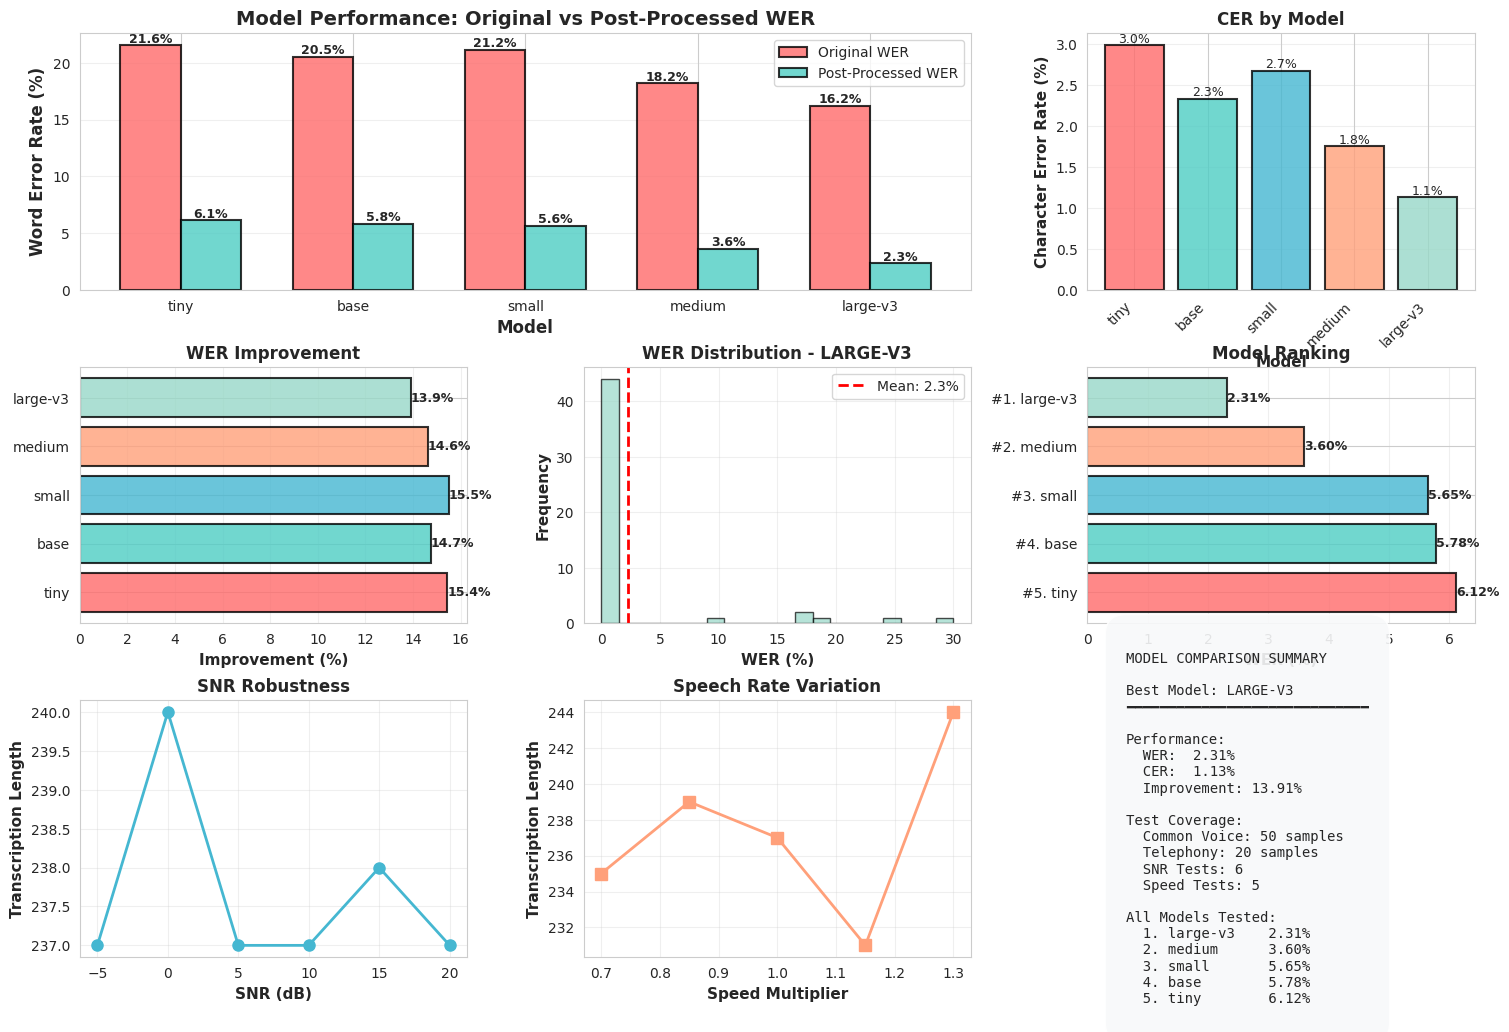

In [27]:
model_names = []
original_wers = []
processed_wers = []
cers = []
colors = []

for model_name, model_data in models_to_test.items():
    if model_data.get('metrics'):
        model_names.append(model_name)
        original_wers.append(model_data['metrics']['original_wer_mean'] * 100)
        processed_wers.append(model_data['metrics']['processed_wer_mean'] * 100)
        cers.append(model_data['metrics']['cer_mean'] * 100)
        colors.append(model_data['color'])

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :2])
x = np.arange(len(model_names))
width = 0.35
bars1 = ax1.bar(x - width/2, original_wers, width, label='Original WER', 
                color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x + width/2, processed_wers, width, label='Post-Processed WER',
                color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Word Error Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance: Original vs Post-Processed WER', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2 = fig.add_subplot(gs[0, 2])
bars = ax2.bar(model_names, cers, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Model', fontsize=11, fontweight='bold')
ax2.set_ylabel('Character Error Rate (%)', fontsize=11, fontweight='bold')
ax2.set_title('CER by Model', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

ax3 = fig.add_subplot(gs[1, 0])
improvements = [(models_to_test[m]['metrics']['improvement'] * 100) for m in model_names]
bars = ax3.barh(model_names, improvements, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Improvement (%)', fontsize=11, fontweight='bold')
ax3.set_title('WER Improvement', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:.1f}%', ha='left', va='center', fontsize=9, fontweight='bold')

ax4 = fig.add_subplot(gs[1, 1])
best_wers = [r['processed_wer'] * 100 for r in models_to_test[best_model_name]['results']]
ax4.hist(best_wers, bins=20, color=models_to_test[best_model_name]['color'], 
         alpha=0.7, edgecolor='black')
ax4.axvline(np.mean(best_wers), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(best_wers):.1f}%')
ax4.set_xlabel('WER (%)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title(f'WER Distribution - {best_model_name.upper()}', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[1, 2])
sorted_models = sorted(model_names, key=lambda m: models_to_test[m]['metrics']['processed_wer_mean'])
sorted_wers = [models_to_test[m]['metrics']['processed_wer_mean'] * 100 for m in sorted_models]
sorted_colors = [models_to_test[m]['color'] for m in sorted_models]
bars = ax5.barh(range(len(sorted_models)), sorted_wers, color=sorted_colors, 
                alpha=0.8, edgecolor='black', linewidth=1.5)
ax5.set_yticks(range(len(sorted_models)))
ax5.set_yticklabels([f"#{i+1}. {m}" for i, m in enumerate(sorted_models)])
ax5.set_xlabel('WER (%)', fontsize=11, fontweight='bold')
ax5.set_title('Model Ranking', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')
ax5.invert_yaxis()
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax5.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:.2f}%', ha='left', va='center', fontsize=9, fontweight='bold')

if snr_results:
    ax6 = fig.add_subplot(gs[2, 0])
    snr_dbs = [r['snr_db'] for r in snr_results]
    transcription_lengths = [r['length'] for r in snr_results]
    ax6.plot(snr_dbs, transcription_lengths, marker='o', linewidth=2, 
             markersize=8, color='#45B7D1')
    ax6.set_xlabel('SNR (dB)', fontsize=11, fontweight='bold')
    ax6.set_ylabel('Transcription Length', fontsize=11, fontweight='bold')
    ax6.set_title('SNR Robustness', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3)

if rate_results:
    ax7 = fig.add_subplot(gs[2, 1])
    rates = [r['rate'] for r in rate_results]
    transcription_lengths = [len(r['transcription']) for r in rate_results]
    ax7.plot(rates, transcription_lengths, marker='s', linewidth=2, 
             markersize=8, color='#FFA07A')
    ax7.set_xlabel('Speed Multiplier', fontsize=11, fontweight='bold')
    ax7.set_ylabel('Transcription Length', fontsize=11, fontweight='bold')
    ax7.set_title('Speech Rate Variation', fontsize=12, fontweight='bold')
    ax7.grid(True, alpha=0.3)

ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')

summary_text = f"""
MODEL COMPARISON SUMMARY

Best Model: {best_model_name.upper()}
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Performance:
  WER:  {models_to_test[best_model_name]['metrics']['processed_wer_mean']:.2%}
  CER:  {models_to_test[best_model_name]['metrics']['cer_mean']:.2%}
  Improvement: {models_to_test[best_model_name]['metrics']['improvement']:.2%}

Test Coverage:
  Common Voice: {len(models_to_test[best_model_name]['results'])} samples
  Telephony: {len(telephony_results)} samples
  SNR Tests: {len(snr_results) if snr_results else 0}
  Speed Tests: {len(rate_results) if rate_results else 0}

All Models Tested:
"""

for i, model in enumerate(sorted_models, 1):
    wer_val = models_to_test[model]['metrics']['processed_wer_mean']
    summary_text += f"  {i}. {model:10s}  {wer_val:.2%}\n"

ax8.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='#F8F9FA', alpha=0.9, pad=1.5))

plt.tight_layout() 
plt.savefig(os.path.join(OUT_DIR, 'comprehensive_analysis.png'), dpi=200, bbox_inches='tight')
plt.show() 

# TELECOM CALL TRANSCRIPTION

In [29]:
print(f"Using model: {best_model_name.upper()}")
print("─"*80 + "\n")

def create_merged_transcript(audio_path, model, model_name):
    """Create detailed transcript with timestamps"""
    try:
        audio, sr = librosa.load(audio_path, sr=16000)
        segments, info = model.transcribe(audio, beam_size=5, language="en")
        
        merged_data = {
            "metadata": {
                "audio_file": os.path.basename(audio_path),
                "duration_seconds": round(len(audio) / sr, 2),
                "sample_rate": sr,
                "model": f"whisper-{model_name}",
                "processing_date": datetime.now().isoformat()
            },
            "segments": []
        }
        
        segment_id = 0
        full_text_parts = []
        
        for segment in segments:
            processed_text = post_process(segment.text)
            full_text_parts.append(processed_text)
            
            merged_data["segments"].append({
                "segment_id": segment_id,
                "start_time": round(segment.start, 3),
                "end_time": round(segment.end, 3),
                "duration": round(segment.end - segment.start, 3),
                "text": processed_text,
                "confidence": round(getattr(segment, 'confidence', 0.0), 3)
            })
            
            segment_id += 1
        
        merged_data["full_transcript"] = " ".join(full_text_parts)
        
        return merged_data
    except Exception as e:
        print(f"Error creating transcript: {e}")
        return None

telecom_audio_path = "/kaggle/input/voice-call-1/telecom_call.mp3"

if os.path.exists(telecom_audio_path):
    print(f"Processing: {os.path.basename(telecom_audio_path)}")
    
    telecom_transcript = create_merged_transcript(telecom_audio_path, best_model, best_model_name)
    
    if telecom_transcript:
        output_path = os.path.join(OUT_DIR, 'telecom_call_transcript.json')
        with open(output_path, 'w') as f:
            json.dump(telecom_transcript, f, indent=2)
        
        print(f"Transcript Statistics:")
        print(f"  Duration:       {telecom_transcript['metadata']['duration_seconds']:.2f}s")
        print(f"  Total Segments: {len(telecom_transcript['segments'])}")
        print(f"  Model Used:     {telecom_transcript['metadata']['model']}")
        
        print(f"Full Transcript:")
        print("─"*80)
        print(telecom_transcript['full_transcript'])
        print("─"*80)
        
        print(f"Detailed Segments:")
        print("─"*80)
        for seg in telecom_transcript['segments']:
            print(f"[{seg['start_time']:6.2f}s - {seg['end_time']:6.2f}s] {seg['text']}")
        
        print("─"*80)
        print(f"Full transcript saved to: {output_path}")
    else:
        print("Failed to create transcript")
else:
    print(f"Audio file not found: {telecom_audio_path}")

Using model: LARGE-V3
────────────────────────────────────────────────────────────────────────────────

Processing: telecom_call.mp3
Transcript Statistics:
  Duration:       160.80s
  Total Segments: 33
  Model Used:     whisper-large-v3
Full Transcript:
────────────────────────────────────────────────────────────────────────────────
Hello Thank you for calling customer support My name is Rajesh How can I help you today? Hi Rajesh I'm really upset My bill this month is way higher than last month I was charged $2500 instead of $1800 What's going on? I completely understand your frustration That's definitely concerning Let me help you figure this out Can I get your phone number please? Sure It's 987-654-320 Thank you Let me check your account I can see the bill increase There are several reasons this could happen Additional data usage new subscriptions service charges or a plan upgrade Let me check your details I don't think I added anything I haven't changed my plan So it must be the da

# EXPORT RESULTS

In [31]:
comparison_summary = {
    "metadata": {
        "project": "ASR Model Comparison Study",
        "timestamp": datetime.now().isoformat(),
        "test_dataset": "Common Voice + LibriSpeech-Noise"
    },
    "models_tested": {},
    "best_model": {
        "name": best_model_name,
        "wer": float(models_to_test[best_model_name]['metrics']['processed_wer_mean']),
        "cer": float(models_to_test[best_model_name]['metrics']['cer_mean']),
        "improvement": float(models_to_test[best_model_name]['metrics']['improvement'])
    },
    "test_coverage": {
        "common_voice_samples": len(cv_df),
        "telephony_samples": len(telephony_results),
        "snr_tests": len(snr_results) if snr_results else 0,
        "rate_tests": len(rate_results) if rate_results else 0
    }
}

for model_name, model_data in models_to_test.items():
    if model_data.get('metrics'):
        comparison_summary["models_tested"][model_name] = {
            "original_wer": float(model_data['metrics']['original_wer_mean']),
            "processed_wer": float(model_data['metrics']['processed_wer_mean']),
            "cer": float(model_data['metrics']['cer_mean']),
            "improvement": float(model_data['metrics']['improvement']),
            "improvement_percentage": float(model_data['metrics']['improvement_pct']),
            "samples_evaluated": len(model_data['results'])
        }

with open(os.path.join(OUT_DIR, 'model_comparison_summary.json'), 'w') as f:
    json.dump(comparison_summary, f, indent=2)

print("Exported model_comparison_summary.json")

with open(os.path.join(OUT_DIR, f'{best_model_name}_detailed_results.json'), 'w') as f:
    json.dump(models_to_test[best_model_name]['results'], f, indent=2)

print(f"Exported {best_model_name}_detailed_results.json")

Exported model_comparison_summary.json
Exported large-v3_detailed_results.json


# FINAL SUMMARY

In [32]:
print("MODEL RANKINGS:")
print("─"*80)
for i, model in enumerate(sorted_models, 1):
    metrics = models_to_test[model]['metrics']
    print(f"{i}. {model.upper():12s}  |  WER: {metrics['processed_wer_mean']:.2%}  |  CER: {metrics['cer_mean']:.2%}  |  Improvement: {metrics['improvement']:.2%}")

print("\n" + "─"*80)
print(f"BEST MODEL: {best_model_name.upper()}")
print(f"   Word Error Rate:  {models_to_test[best_model_name]['metrics']['processed_wer_mean']:.2%}")
print(f"   Char Error Rate:  {models_to_test[best_model_name]['metrics']['cer_mean']:.2%}")
print(f"   Improvement:      {models_to_test[best_model_name]['metrics']['improvement']:.2%}")

print("\n" + "─"*80)
print("\nFILES GENERATED:")
print("  • comprehensive_analysis.png")
print("  • model_comparison_summary.json")
print(f"  • {best_model_name}_detailed_results.json")
print("  • telecom_call_transcript.json")

MODEL RANKINGS:
────────────────────────────────────────────────────────────────────────────────
1. LARGE-V3      |  WER: 2.31%  |  CER: 1.13%  |  Improvement: 13.91%
2. MEDIUM        |  WER: 3.60%  |  CER: 1.75%  |  Improvement: 14.61%
3. SMALL         |  WER: 5.65%  |  CER: 2.68%  |  Improvement: 15.50%
4. BASE          |  WER: 5.78%  |  CER: 2.33%  |  Improvement: 14.74%
5. TINY          |  WER: 6.12%  |  CER: 2.99%  |  Improvement: 15.44%

────────────────────────────────────────────────────────────────────────────────
BEST MODEL: LARGE-V3
   Word Error Rate:  2.31%
   Char Error Rate:  1.13%
   Improvement:      13.91%

────────────────────────────────────────────────────────────────────────────────

FILES GENERATED:
  • comprehensive_analysis.png
  • model_comparison_summary.json
  • large-v3_detailed_results.json
  • telecom_call_transcript.json
